# Kurulum ve Datasetin Oluşturulması

### Kütüphaneler

Kullanılan kütüphaneler import edilmiş ve random fonksiyonları seedlenmiştir.

In [66]:
import torch
import random
import wandb
import os

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from kaggle_secrets import UserSecretsClient
from datetime import datetime, timedelta
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Farklı değişkenlerle eğittiğimiz modellerin takibini yapabilmek için WanDb'ye kayıt oluyoruz.

In [67]:
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login(relogin=False)

True

Her hisse senedinin hareketleri kendine özgü olduğundan genel bir model eğitmek yerine her hisse senedi için ayrı bir model eğitmeye karar verdik. Burada seçtiğimiz senet için açılış fiyatı ve ticaret hacmi gibi kullanmayacağımız özellikleri filtreliyoruz.

In [68]:
ticker = "MSFT"
file_path = f"/kaggle/input/stock-market-data/stock_market_data/nasdaq/csv/{ticker}.csv"

df = pd.read_csv(file_path, usecols=["Date", "Close"])
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df[["Close"]])

print(df)

df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")
df.dropna(subset=["Date"], inplace=True)
df.set_index("Date", inplace=True)

            Date     Close
0     13-03-1986  0.000020
1     14-03-1986  0.000030
2     17-03-1986  0.000035
3     18-03-1986  0.000028
4     19-03-1986  0.000023
...          ...       ...
9259  06-12-2022  0.714331
9260  07-12-2022  0.712145
9261  08-12-2022  0.720978
9262  09-12-2022  0.715206
9263  12-12-2022  0.730511

[9264 rows x 2 columns]


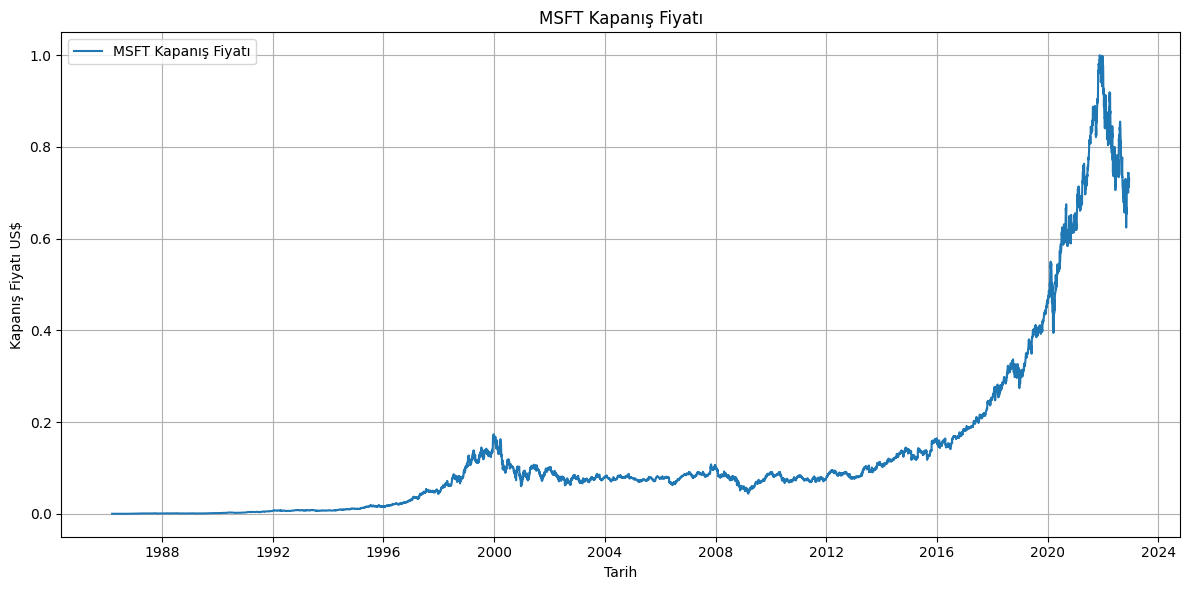

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label=f"{ticker} Kapanış Fiyatı")

plt.title(f"{ticker} Kapanış Fiyatı")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı US$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Verilerimizi zaman serisi hâline dönüştürüyoruz. Bu fonksiyon internette bulunabileceği için tekrar yazma gereği duymadık.

In [70]:
def df_to_windowed_df(df, start_date, end_date, window_size=3):
    start_date = pd.to_datetime(start_date, format="%d-%m-%Y")
    end_date = pd.to_datetime(end_date, format="%d-%m-%Y")

    dates = []
    X, Y = [], []

    date_range = df.loc[start_date:end_date].index

    for i in range(window_size, len(date_range)):
        window_dates = date_range[i - window_size:i + 1]
        window_values = df.loc[window_dates, "Close"].values

        if len(window_values) != window_size + 1:
            continue

        x, y = window_values[:-1], window_values[-1]

        dates.append(window_dates[-1])
        X.append(x)
        Y.append(y)

    windowed_df = pd.DataFrame(X, columns=[f"Target-{i}" for i in range(window_size, 0, -1)])
    windowed_df["Target"] = Y
    windowed_df["Target Date"] = dates

    return windowed_df[["Target Date"] + [f"Target-{i}" for i in range(window_size, 0, -1)] + ["Target"]]

windowed_df = df_to_windowed_df(df, "25-03-2005", "23-03-2022", window_size=21)
windowed_df

,Target Date,Target-21,Target-20,Target-19,Target-18,Target-17,Target-16,Target-15,Target-14,Target-13,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2005-04-26,0.070287,0.069470,0.070170,0.070199,0.070053,0.070374,0.071074,0.071657,0.072910,...,0.072736,0.072152,0.071045,0.071599,0.071540,0.070637,0.073435,0.072561,0.072590,0.071919
1,2005-04-27,0.069470,0.070170,0.070199,0.070053,0.070374,0.071074,0.071657,0.072910,0.072444,...,0.072152,0.071045,0.071599,0.071540,0.070637,0.073435,0.072561,0.072590,0.071919,0.072590
2,2005-04-28,0.070170,0.070199,0.070053,0.070374,0.071074,0.071657,0.072910,0.072444,0.072531,...,0.071045,0.071599,0.071540,0.070637,0.073435,0.072561,0.072590,0.071919,0.072590,0.071016
3,2005-04-29,0.070199,0.070053,0.070374,0.071074,0.071657,0.072910,0.072444,0.072531,0.073552,...,0.071599,0.071540,0.070637,0.073435,0.072561,0.072590,0.071919,0.072590,0.071016,0.073494
4,2005-05-02,0.070053,0.070374,0.071074,0.071657,0.072910,0.072444,0.072531,0.073552,0.072736,...,0.071540,0.070637,0.073435,0.072561,0.072590,0.071919,0.072590,0.071016,0.073494,0.073289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,2022-03-17,0.875692,0.872864,0.847297,0.839135,0.838522,0.816804,0.858550,0.866480,0.870795,...,0.844761,0.812839,0.803918,0.840796,0.832313,0.816221,0.805638,0.836861,0.857967,0.860387
4254,2022-03-18,0.872864,0.847297,0.839135,0.838522,0.816804,0.858550,0.866480,0.870795,0.859600,...,0.812839,0.803918,0.840796,0.832313,0.816221,0.805638,0.836861,0.857967,0.860387,0.875576
4255,2022-03-21,0.847297,0.839135,0.838522,0.816804,0.858550,0.866480,0.870795,0.859600,0.874876,...,0.803918,0.840796,0.832313,0.816221,0.805638,0.836861,0.857967,0.860387,0.875576,0.871873
4256,2022-03-22,0.839135,0.838522,0.816804,0.858550,0.866480,0.870795,0.859600,0.874876,0.862428,...,0.840796,0.832313,0.816221,0.805638,0.836861,0.857967,0.860387,0.875576,0.871873,0.886158


In [71]:
def windowed_df_to_date_X_y(windowed_df):
    feature_cols = [col for col in windowed_df.columns if col.startswith("Target-")]
    target_col = "Target"
    date_col = "Target Date"

    dates = windowed_df[date_col].to_numpy()
    X = windowed_df[feature_cols].to_numpy().astype(np.float32).reshape(len(dates), len(feature_cols), 1)
    y = windowed_df[target_col].to_numpy().astype(np.float32)

    return dates, X, y

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((4258,), (4258, 21, 1), (4258,))

Scikit'teki train test split fonksiyonunu kullanmama sebebimiz verimizin zaman serisi hâlinde olması. Dolayısıyla list slicing ile yaptık.

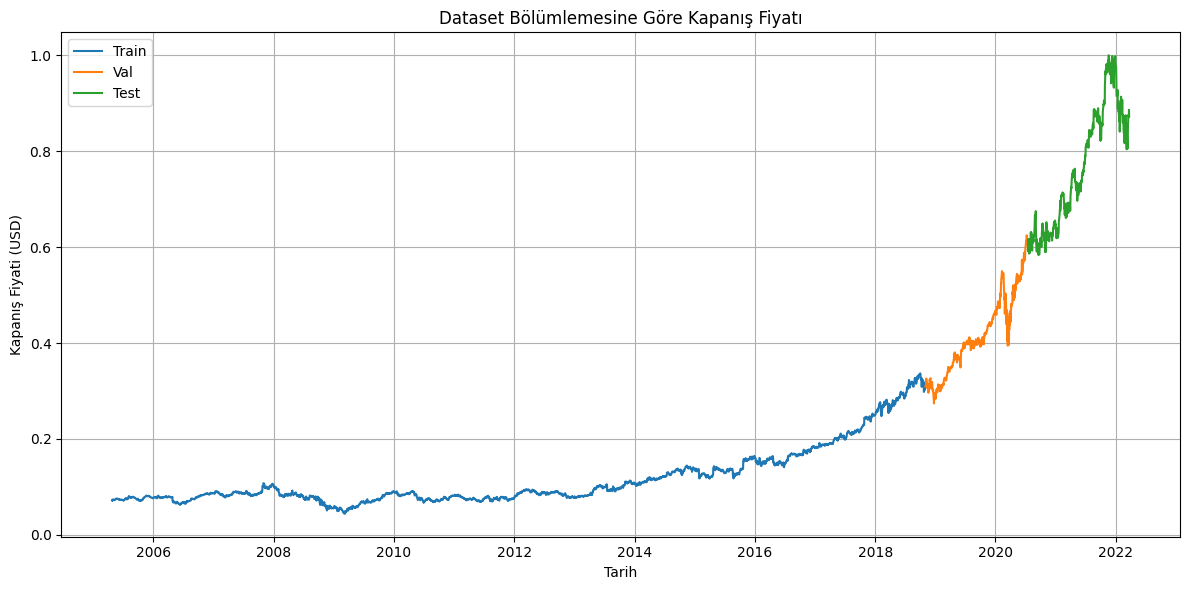

In [72]:
    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)
    
    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(dates_train, y_train, label="Train")
    plt.plot(dates_val, y_val, label="Val")
    plt.plot(dates_test, y_test, label="Test")
    
    plt.title("Dataset Bölümlemesine Göre Kapanış Fiyatı")
    plt.xlabel("Tarih")
    plt.ylabel("Kapanış Fiyati (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Modelin Oluşturulması ve Eğitimi

In [73]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Kullanılan cihaz:", device)

Kullanılan cihaz: cpu


LSTM modelimizi oluşturuyoruz. Modelimizin çift yönlü farkındalığa sahip olması bidirectional=True olarak ayarlıyoruz. Mean squared error (MSE) loss fonksiyonunu ve Adam optimizerını kullanacağız. Ayrıca loss fonksiyonun grafiği düzleşmeye başladıkça learning rate'i yani model ağırlıklarının güncellenme hızını azaltmak için ReduceLROnPlateau classını kullanıyoruz.

In [74]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, fc_dim=32):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = True

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        lstm_output_dim = hidden_dim * 2 if self.bidirectional else hidden_dim

        self.fc = nn.Sequential(
            nn.Linear(lstm_output_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq, hidden_dim * 2)
        last_hidden = lstm_out[:, -1, :]
        return self.fc(last_hidden)

model = LSTMModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=5, factor=0.5
)

In [75]:
def to_tensor_dataset(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return TensorDataset(X_tensor, y_tensor)

train_loader = DataLoader(to_tensor_dataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(to_tensor_dataset(X_val, y_val), batch_size=32)

Modellerimizin eğitim verilerinin takibi için kullanacağımız Wandb configini ayarlıyoruz.

In [76]:
wandb.init(
    project="Hisse Fiyatı Tahminleyicisi",
    config={
        "model": "LSTM",
        "window_size": 21,
        "hidden_dim": 64,
        "fc_dim": 32,
        "batch_size": 32,
        "lr": 1e-3,
        "epochs": 250,
        "patience": 15,
    }
)

Model eğitim döngümüz:

In [77]:
best_val_loss = float("inf")
best_model_state = None
patience = 15
epochs_without_improve = 0

for epoch in range(1, 251):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            batch_loss = criterion(predictions, y_batch)
            val_loss += batch_loss.item() * X_batch.size(0)
            val_mae += torch.sum(torch.abs(predictions - y_batch)).item()

    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_model.pth")
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1
        if epochs_without_improve == patience:
            print(f"Model öğrenmeyi durdurdu, erken durdurma {epoch}. epoch'ta çalıştırıldı.1")
            break

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_mae": val_mae,
        "lr": optimizer.param_groups[0]["lr"]
    })

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, Val MAE = {val_mae:.4f}")

Epoch  10: Train Loss = 0.000019, Val Loss = 0.001179, Val MAE = 0.0250
Epoch  20: Train Loss = 0.000012, Val Loss = 0.000516, Val MAE = 0.0177
Epoch  30: Train Loss = 0.000008, Val Loss = 0.000165, Val MAE = 0.0092
Epoch  40: Train Loss = 0.000006, Val Loss = 0.000106, Val MAE = 0.0072
Epoch  50: Train Loss = 0.000005, Val Loss = 0.000094, Val MAE = 0.0066
Epoch  60: Train Loss = 0.000004, Val Loss = 0.000101, Val MAE = 0.0071
Model öğrenmeyi durdurdu, erken durdurma 62. epoch'ta çalıştırıldı.1


Modelimizin ağırlık dosyasını Wandb'ye yüklüyoruz.

In [78]:
model.load_state_dict(torch.load("best_model.pth"))
print("Kaydedilen en iyi model yüklendi.")

artifact = wandb.Artifact(
    name=ticker,
    type="model",
    metadata={"window_size": 21, "bidirectional": True}
)

artifact.add_file("best_model.pth")
wandb.log_artifact(artifact)

Kaydedilen en iyi model yüklendi.


<Artifact MSFT>

# Modelin Değerlendirilmesi

In [79]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    train_preds = model(X_train_tensor).squeeze().cpu().numpy()
    val_preds = model(X_val_tensor).squeeze().cpu().numpy()
    test_preds = model(X_test_tensor).squeeze().cpu().numpy()

y_train_real = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_real   = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_real  = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

train_preds_real = scaler.inverse_transform(train_preds.reshape(-1, 1)).flatten()
val_preds_real   = scaler.inverse_transform(val_preds.reshape(-1, 1)).flatten()
test_preds_real  = scaler.inverse_transform(test_preds.reshape(-1, 1)).flatten()

In [81]:
def evaluate_predictions(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"{name} MAE:   {mae:.4f}")
    print(f"{name} RMSE:  {rmse:.4f}")
    print(f"{name} MAPE:  {mape:.2f}%")
    print(f"{name} R²:    {r2:.4f}")
    print()

    return {"mae": mae, "rmse": rmse, "mape": mape, "r2": r2}

wandb.log({
    "test_mae": test_metrics["mae"],
    "test_rmse": test_metrics["rmse"],
    "test_mape": test_metrics["mape"],
    "test_r2": test_metrics["r2"]
})

wandb.finish()

Train MAE:   0.5000
Train RMSE:  0.7592
Train MAPE:  1.32%
Train R²:    0.9987

Val MAE:   2.0736
Val RMSE:  3.2178
Val MAPE:  1.44%
Val R²:    0.9869

Test MAE:   3.5700
Test RMSE:  4.7213
Test MAPE:  1.37%
Test R²:    0.9877



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
lr,██████████████████████████▄▄▄▄▄▄▄▄▂▂▂▂▁▁
test_mae,▁
test_mape,▁
test_r2,▁
test_rmse,▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▃▅▄▄▃▃▃▃▂▂▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,▇▇▇█▄▅▅▄▄▄▄▄▃▃▂▅▂▃▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,61
lr,0.00013


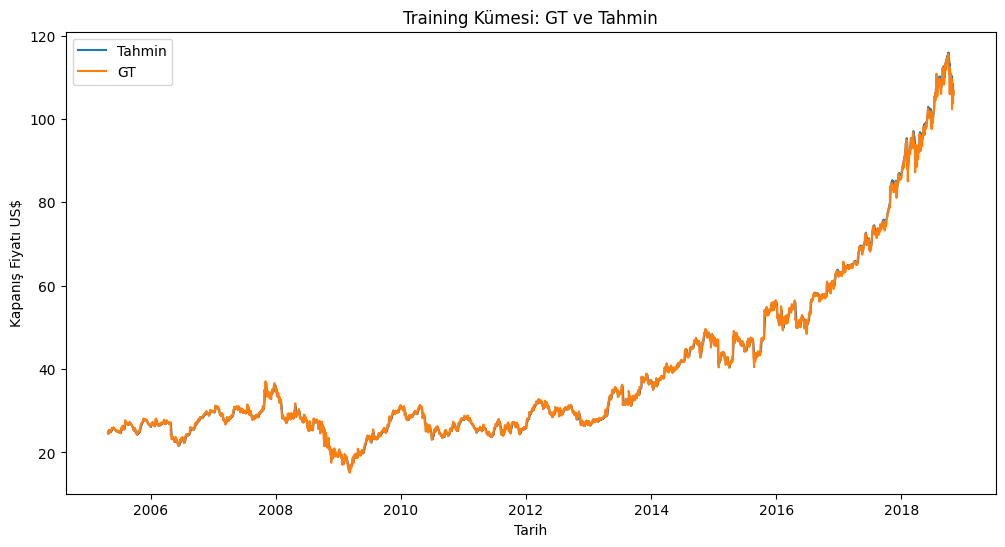

In [80]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).squeeze().cpu().numpy()
    

assert len(train_preds) == len(dates_train) == len(y_train)

train_metrics = evaluate_predictions(y_train_real, train_preds_real, name="Train")

plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_preds_real, label="Tahmin")
plt.plot(dates_train, y_train_real, label="GT")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı US$")
plt.title("Training Kümesi: GT ve Tahmin")
plt.legend()
plt.show()

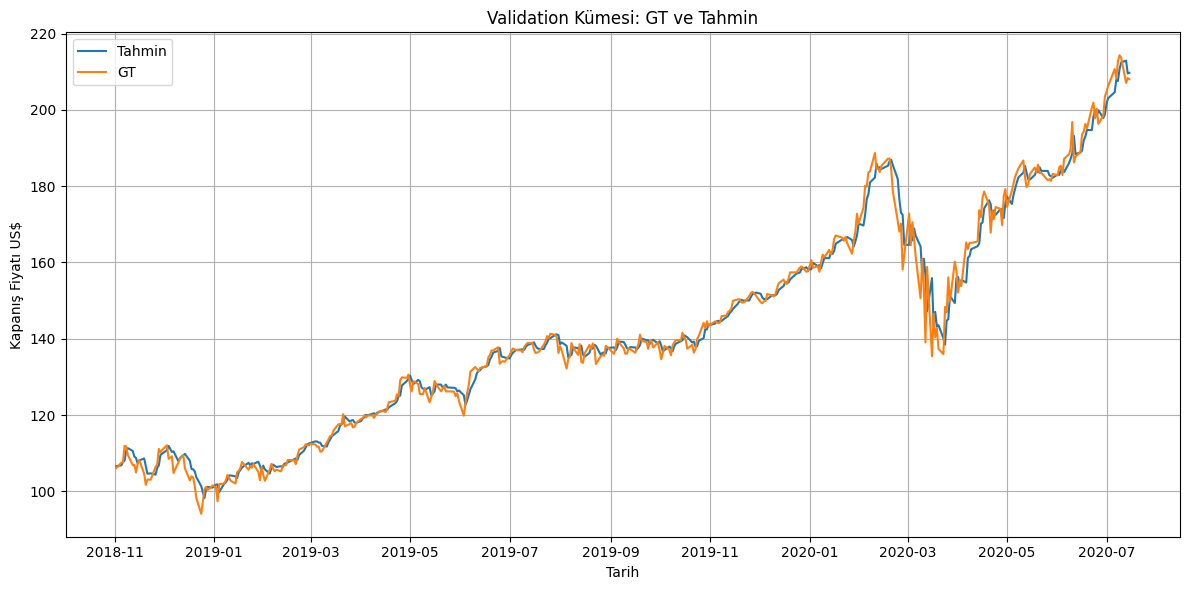

In [82]:
model.eval()

X_val_tensor_device = X_val_tensor.to(device)

with torch.no_grad():
    val_preds = model(X_val_tensor_device).cpu().squeeze().numpy()

val_metrics = evaluate_predictions(y_val_real, val_preds_real, name="Val")

plt.figure(figsize=(12, 6))
plt.plot(dates_val, val_preds_real, label="Tahmin")
plt.plot(dates_val, y_val_real, label="GT")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı US$")
plt.title("Validation Kümesi: GT ve Tahmin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

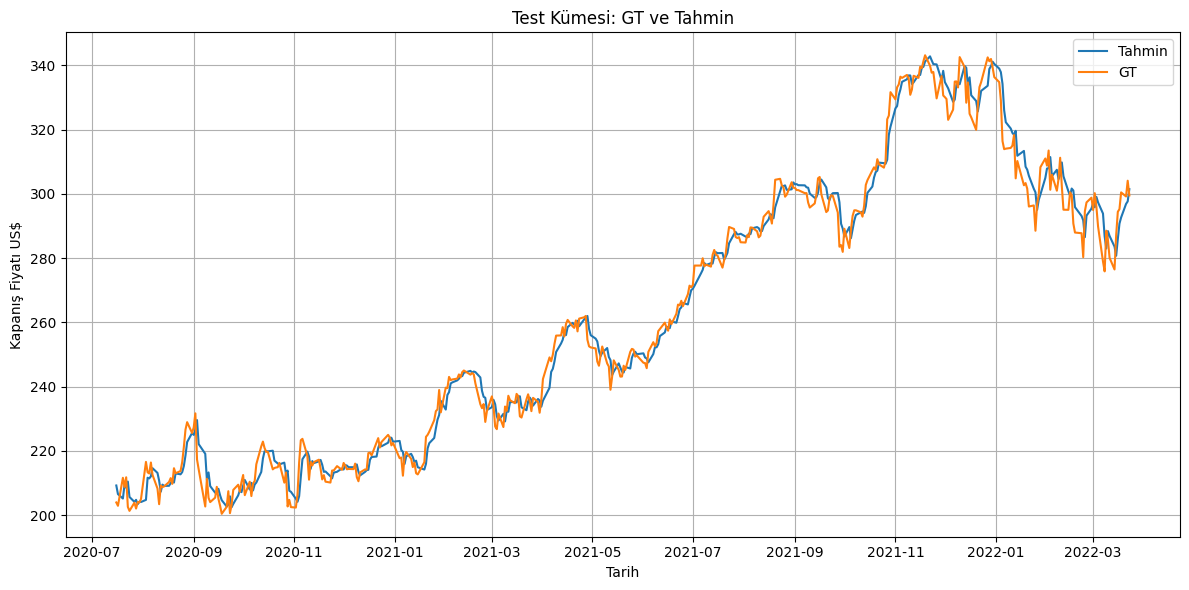

In [83]:
model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    test_preds = model(X_test_tensor).cpu().squeeze().numpy()

test_metrics = evaluate_predictions(y_test_real, test_preds_real, name="Test")


plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_preds_real, label="Tahmin")
plt.plot(dates_test, y_test_real, label="GT")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı US$")
plt.title("Test Kümesi: GT ve Tahmin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

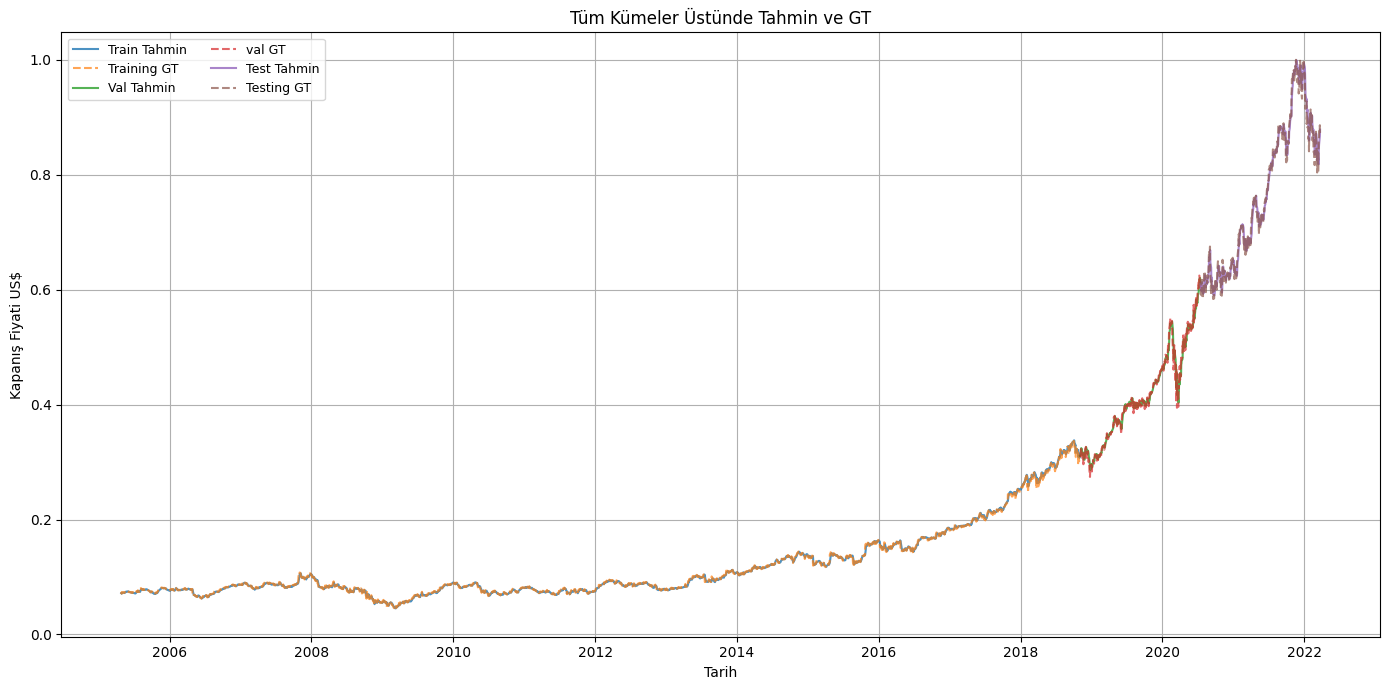

In [84]:
plt.figure(figsize=(14, 7))

plt.plot(dates_train, train_preds, label="Train Tahmin", alpha=0.8)
plt.plot(dates_train, y_train, label="Training GT", linestyle="dashed", alpha=0.7)

plt.plot(dates_val, val_preds, label="Val Tahmin", alpha=0.8)
plt.plot(dates_val, y_val, label="val GT", linestyle="dashed", alpha=0.7)

plt.plot(dates_test, test_preds, label="Test Tahmin", alpha=0.8)
plt.plot(dates_test, y_test, label="Testing GT", linestyle="dashed", alpha=0.7)

plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyati US$")
plt.title("Tüm Kümeler Üstünde Tahmin ve GT")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

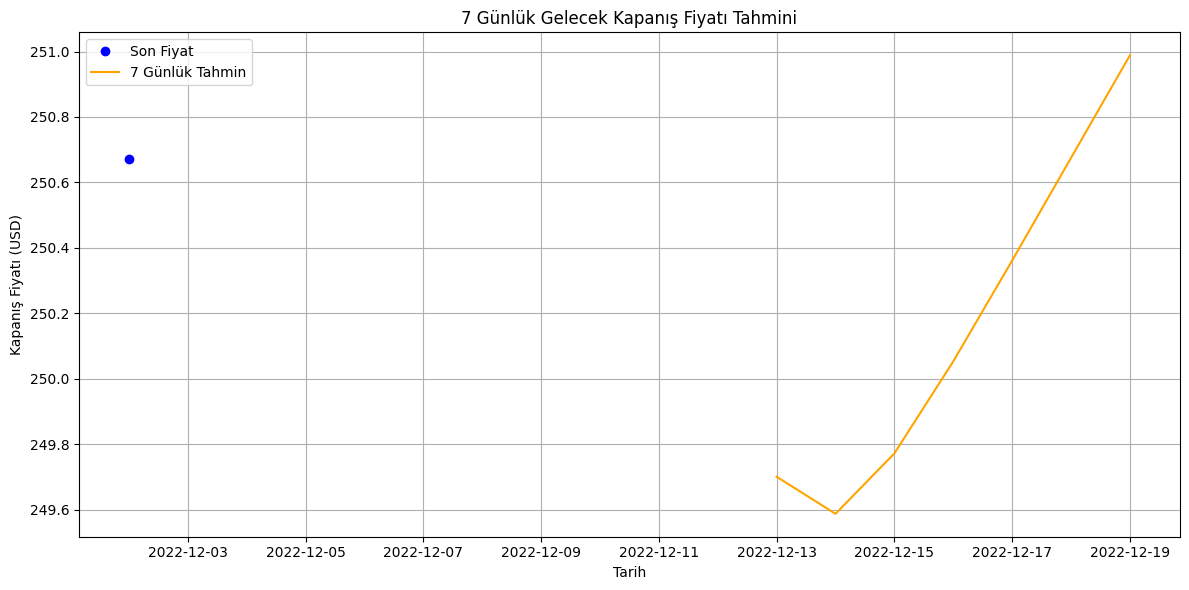

In [85]:
def forecast_future_prices(model, df, window_size, scaler, days_ahead=7):
    model.eval()

    last_window_scaled = df["Close"].values[-window_size:].astype(np.float32).reshape(1, window_size, 1)
    input_tensor = torch.tensor(last_window_scaled, dtype=torch.float32).to(device)

    predicted_scaled = []

    with torch.no_grad():
        for _ in range(days_ahead):
            pred = np.float32(model(input_tensor).cpu().item())
            predicted_scaled.append(pred)

            new_input = input_tensor.cpu().numpy().squeeze().astype(np.float32)
            new_input = np.append(new_input[1:], pred).astype(np.float32)
            input_tensor = torch.tensor(new_input.reshape(1, window_size, 1), dtype=torch.float32).to(device)

    predicted_prices = scaler.inverse_transform(np.array(predicted_scaled).reshape(-1, 1)).flatten()
    last_date = df.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(days_ahead)]

    return future_dates, predicted_prices


future_dates, future_prices = forecast_future_prices(
    model=model,
    df=df,
    window_size=21,
    scaler=scaler,
    days_ahead=7
)

plt.figure(figsize=(12, 6))

last_date = df.index[-7]
last_price = scaler.inverse_transform(df[["Close"]].values[-1].reshape(1, -1)).item()
plt.plot([last_date], [last_price], 'bo', label="Son Fiyat")

plt.plot(future_dates, future_prices, label="7 Günlük Tahmin", color='orange')

plt.title("7 Günlük Gelecek Kapanış Fiyatı Tahmini")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()